# CNN on the dection of dizziness onset and quantification

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from utils.eeglib.helpers import CSVCustomHelper, CSVHelper
from utils.eeglib.helpers import Helper
import os

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
def extract_average_metrics(report):
    average_metrics = report['weighted avg'] 
    return average_metrics['precision'], average_metrics['recall'], average_metrics['f1-score']

def map_labels(y, classes):
    return y.map(classes)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{height:.2f}', ha='center', va='bottom', fontsize=13)

## Preparing Data

### Load data and filtering

In [4]:
all_directories = {
    '1712262127_Brian': {
        '1712262127_Brian/1712262127_BASE_LINE': 'BASE_LINE',
        '1712262127_Brian/1712262819_VOR_1HZ': 'VOR_1HZ',
        # '1712262127_Brian/1712263003_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1712262127_Brian/1712263704_VOR_2HZ': 'VOR_2HZ',
        # '1712262127_Brian/1712263852_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1712262127_Brian/1712264509_VOR_3HZ': 'VOR_3HZ',
        # '1712262127_Brian/1712264650_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1712262127_Brian/1712265369_VOR_4HZ': 'VOR_4HZ',
        # '1712262127_Brian/1712265511_VOR_4HZ_REST': 'VOR_4HZ_REST'
    },
        
    '1712094934_Nhan': {
        '1712094934_Nhan/1712094934_BASE_LINE': 'BASE_LINE',
        '1712094934_Nhan/1712095682_VOR_1HZ': 'VOR_1HZ',
        # '1712094934_Nhan/1712095831_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1712094934_Nhan/1712096475_VOR_2HZ': 'VOR_2HZ',
        # '1712094934_Nhan/1712096619_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1712094934_Nhan/1712097275_VOR_3HZ': 'VOR_3HZ',
        # '1712094934_Nhan/1712097418_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1712094934_Nhan/1712098656_VOR_4HZ': 'VOR_4HZ',
        # '1712094934_Nhan/1712098799_VOR_4HZ_REST': 'VOR_4HZ_REST'
    },

    '1712270250_Onila': {
        '1712270250_Onila/1712270250_BASE_LINE': 'BASE_LINE',
        '1712270250_Onila/1712270977_VOR_1HZ': 'VOR_1HZ',
        # '1712270250_Onila/1712271123_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1712270250_Onila/1712271878_VOR_2HZ': 'VOR_2HZ',
        # '1712270250_Onila/1712272019_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1712270250_Onila/1712272675_VOR_3HZ': 'VOR_3HZ',
        # '1712270250_Onila/1712272768_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1712270250_Onila/1712273445_VOR_4HZ': 'VOR_4HZ',
        # '1712270250_Onila/1712273580_VOR_4HZ_REST': 'VOR_4HZ_REST'
    },

    '1713293584_Jacob': {
        '1713293584_Jacob/1713293584_BASE_LINE': 'BASE_LINE',
        '1713293584_Jacob/1713294328_VOR_1HZ': 'VOR_1HZ',
        # '1713293584_Jacob/1713294472_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1713293584_Jacob/1713295133_VOR_2HZ': 'VOR_2HZ',
        # '1713293584_Jacob/1713295276_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1713293584_Jacob/1713295919_VOR_3HZ': 'VOR_3HZ',
        # '1713293584_Jacob/1713296059_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1713293584_Jacob/1713296831_VOR_4HZ': 'VOR_4HZ',
        # '1713293584_Jacob/1713296971_VOR_4HZ_REST': 'VOR_4HZ_REST'
    },

    '1713550894_AlexKagoda' : {
        '1713550894_AlexKagoda/1713550894_BASE_LINE': 'BASE_LINE',
        '1713550894_AlexKagoda/1713551593_VOR_1HZ': 'VOR_1HZ',
        # '1713550894_AlexKagoda/1713551737_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1713550894_AlexKagoda/1713552395_VOR_2HZ': 'VOR_2HZ',
        # '1713550894_AlexKagoda/1713552534_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1713550894_AlexKagoda/1713553173_VOR_3HZ': 'VOR_3HZ',
        # '1713550894_AlexKagoda/1713553317_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1713550894_AlexKagoda/1713554089_VOR_4HZ': 'VOR_4HZ',
        # '1713550894_AlexKagoda/1713554229_VOR_4HZ_REST': 'VOR_4HZ_REST'
    },

    '1713820773_Andrew': {
        '1713820773_Andrew/1713820773_BASE_LINE': 'BASE_LINE',
        '1713820773_Andrew/1713821448_VOR_1HZ': 'VOR_1HZ',
        # '1713820773_Andrew/1713821595_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1713820773_Andrew/1713822396_VOR_2HZ': 'VOR_2HZ',
        # '1713820773_Andrew/1713822537_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1713820773_Andrew/1713823177_VOR_3HZ': 'VOR_3HZ',
        # '1713820773_Andrew/1713823316_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1713820773_Andrew/1713823947_VOR_4HZ': 'VOR_4HZ',
        # '1713820773_Andrew/1713824087_VOR_4HZ_REST': 'VOR_4HZ_REST'
    },

    # Saad
    '1713994149_Saad': {
        '1713994149_Saad/1713994149_BASE_LINE': 'BASE_LINE',
        '1713994149_Saad/1713994824_VOR_1HZ': 'VOR_1HZ',
        # '1713994149_Saad/1713994964_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1713994149_Saad/1713995471_VOR_2HZ': 'VOR_2HZ',
        # '1713994149_Saad/1713995610_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1713994149_Saad/1713996271_VOR_3HZ': 'VOR_3HZ',
        # '1713994149_Saad/1713996412_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1713994149_Saad/1713996958_VOR_4HZ': 'VOR_4HZ',
        # '1713994149_Saad/1713997104_VOR_4HZ_REST': 'VOR_4HZ_REST'
    }, 
    
    # '1713458084_Andrei': {
    #     '1713458084_Andrei/1713458084_BASE_LINE': 'BASE_LINE',
    # },

    # Nathan
    '1714511822_Nathan': {
        '1714511822_Nathan/1714511822_BASE_LINE': 'BASE_LINE',
        '1714511822_Nathan/1714512555_VOR_1HZ': 'VOR_1HZ',
        # '1714511822_Nathan/1714512696_VOR_1HZ_REST': 'VOR_1HZ_REST',
        '1714511822_Nathan/1714513251_VOR_2HZ': 'VOR_2HZ',
        # '1714511822_Nathan/1714513389_VOR_2HZ_REST': 'VOR_2HZ_REST',
        '1714511822_Nathan/1714513724_VOR_3HZ': 'VOR_3HZ',
        # '1714511822_Nathan/1714513865_VOR_3HZ_REST': 'VOR_3HZ_REST',
        '1714511822_Nathan/1714514222_VOR_4HZ': 'VOR_4HZ',
        # '1714511822_Nathan/1714514362_VOR_4HZ_REST': 'VOR_4HZ_REST'
    }, 
}

from utils.signal_processing import *
from utils.utils import *

fs = 250
eeg_chans = 4

processed_data = {}
labels = {}

######################################################################################
# Load the data and do the filtering
######################################################################################
for person, directories in all_directories.items():
    if person == '1713458084_Andrei':
        stim1_idx = 670*fs
        post_stim1_idx = 950*fs

        stim2_idx = 1680*fs
        post_stim2_idx = 1840*fs

        stim3_idx = 2510*fs
        post_stim3_idx = 2642*fs

        stim4_idx = 3394*fs
        post_stim4_idx = 3520*fs
        csvHelper= CSVCustomHelper(directories, cutoff=[(stim1_idx, post_stim1_idx), 
                                                        (stim2_idx, post_stim2_idx), 
                                                        (stim3_idx, post_stim3_idx), 
                                                        (stim4_idx, post_stim4_idx)])
    else:
        csvHelper= CSVCustomHelper(directories)

    
    raw_data, channel_names, length = csvHelper.data, csvHelper.names, csvHelper.lengths
    eeg_data, eog_data, ecg_data, eda_data, imu_data, subjective_feedback = raw_data[:4], raw_data[4:6], raw_data[6], raw_data[7], raw_data[8:11], raw_data[11]
    n_samples = raw_data.shape[1]
        
    if person == '1713458084_Andrei':
        # Dizziness onset
        post_stim1_idx = 670*fs
        post_stim2_idx = post_stim1_idx + 730*fs
        post_stim3_idx = post_stim2_idx + 670*fs
        post_stim4_idx = post_stim3_idx + 752*fs
    else:           
        # Dizziness onset
        post_stim1_idx = length['BASE_LINE']
        post_stim2_idx = post_stim1_idx + length['VOR_1HZ']
        post_stim3_idx = post_stim2_idx + length['VOR_2HZ']
        post_stim4_idx = post_stim3_idx + length['VOR_3HZ']
        post_stim5_idx = post_stim4_idx + length['VOR_4HZ']
                
    filtered_eeg = filter_eeg(eeg_data.copy(), fs, [1,50])
    filtered_eog = filter_eeg(eog_data.copy(), fs, [1,50])
    filtered_ecg = filter_eeg(ecg_data.copy().reshape(1, n_samples), fs, [1,50])
    filtered_eda = filter_eeg(eda_data.copy().reshape(1, n_samples), fs, [0.1,10])
    imu_features = extract_imu_feature(imu_data.copy(), fs)
    
    # Clean EEG one more time
    # clean_eeg = filter_eeg(eeg_data, fs, [5,50])
    
    # Save the data
    # filtered_ecg = filtered_ecg.reshape(1, n_samples)
    # filtered_eda = filtered_eda.reshape(1, n_samples)
    subjective_feedback = subjective_feedback.reshape(1, n_samples)
    
    
    ######################################################################################
    delta_time = 30
    
    
    ######################################################################################
    # Labeling the raw data
    ######################################################################################    
    window_stride_size_seconds_base = 1
    window_stride_size_samples_base = window_stride_size_seconds_base*fs

    # window_stride_size_seconds_non_base = 1
    window_stride_size_samples_non_base = 125   
    
    subjective_feedback[subjective_feedback == 0.] = 1.
    subjective_feedback[post_stim1_idx:] = 0.

    subjective_feedback[post_stim2_idx - delta_time*fs : post_stim2_idx] = 2.
    subjective_feedback[post_stim3_idx - delta_time*fs : post_stim3_idx] = 3.
    subjective_feedback[post_stim4_idx - delta_time*fs : post_stim4_idx] = 4.
    subjective_feedback[post_stim5_idx - delta_time*fs : post_stim5_idx] = 5.
    
    ######################################################################################
    # Concatenate along the feature dimension (axis 0)
    ######################################################################################   
    filtered_data = np.concatenate(
        [filtered_eeg, filtered_eog, filtered_ecg, filtered_eda, subjective_feedback],
        axis=0
    )
    
    # Filter out samples (columns) where subjective_feedback is 0
    valid_indices = subjective_feedback != 0
    filtered_data = filtered_data[:, valid_indices[0]]
    
    ######################################################################################
    # Labeling the processed data
    ######################################################################################
    # Window for each labels
    window_size_seconds = 1
    window_size_samples = window_size_seconds*fs
    
    setups = [[0, post_stim1_idx, window_stride_size_samples_base, 0], 
              [post_stim2_idx-delta_time*fs, post_stim2_idx, window_stride_size_samples_non_base, 1], 
              [post_stim3_idx-delta_time*fs, post_stim3_idx, window_stride_size_samples_non_base, 2],
              [post_stim4_idx-delta_time*fs, post_stim4_idx, window_stride_size_samples_non_base, 3],
              [post_stim5_idx-delta_time*fs, post_stim5_idx, window_stride_size_samples_non_base, 4]]
    
    data = []
    
    for [begin, stop, stride, y] in setups:
        for start in range(begin, stop, stride):
            end = start + window_size_samples
            
            if end > stop:
                break
            
            data.append(filtered_data[:-1, start:end])
            labels.setdefault(person, []).append(y)
            
    data = np.array(data)
    labels[person] = np.array(labels[person])
    
    # labels[person][labels[person] > 0] = 1
    
    ######################################################################################
    # Normalize the data individually
    ######################################################################################
    # Reshape data to (N*1250, 8)
    windows, features, samples = data.shape
    reshaped_data = data.transpose(0, 2, 1).reshape(-1, features)  # Shape: (N*1250, 8)

    # Apply StandardScaler to normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(reshaped_data)  # Shape: (N*1250, 8)

    # Reshape back to (N, 1250, 8)
    reshaped_normalized_data = normalized_data.reshape(windows, samples, features)  # Shape: (N, 1250, 8)
    
    # Store the processed data
    processed_data[person] = reshaped_normalized_data


### Training

In [10]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from tensorflow.keras.utils import to_categorical
# from sklearn.decomposition import PCA
# from utils.tensorflow_model import StandardModel
# import numpy as np
# import os
# from pathlib import Path
# import seaborn as sns
# import matplotlib.pyplot as plt

features = 8
modelDir = 'Models'
modelName = 'dizziness_onset'

# all_persons = list(processed_data.keys())
# accuracies = []
# confusion_matrices = []

# LOOCV - Leave-One-Out Cross-Validation
# for test_person in all_persons:
#     classes = len(np.unique(labels[test_person]))
    
#     # Prepare training data
#     X_train = np.concatenate([processed_data[person] for person in all_persons if person != test_person])
#     y_train = np.concatenate([labels[person] for person in all_persons if person != test_person])
    
#     # Prepare testing data
#     X_test = processed_data[test_person]
#     y_test = labels[test_person]

#     # Reshape for PCA
#     X_train_reshaped = X_train.reshape(-1, features)  # Shape: (N*1250, 8)
#     X_test_reshaped = X_test.reshape(-1, features)    # Shape: (N*1250, 8)

#     # Apply PCA
#     pca = PCA(n_components=8)
#     X_train_pca = pca.fit_transform(X_train_reshaped) [:,:2] # Fit PCA on training data and transform
#     X_test_pca = pca.transform(X_test_reshaped) [:,:2]        # Transform test data using the same PCA

#     # Reshape back for the model
#     X_train_pca = X_train_pca.reshape(-1, window_size_samples, 2, 1)  # Shape: (N, 1250, 2, 1)
#     X_test_pca = X_test_pca.reshape(-1, window_size_samples, 2, 1)    # Shape: (N, 1250, 2, 1)

#     # One-hot encode the labels
#     y_train = to_categorical(y_train, num_classes=classes)
#     y_test = to_categorical(y_test, num_classes=classes)

#     # Initialize and train the model
#     print(f'Start training the model for {test_person}')
#     tfStandardModel = StandardModel(windowSize=window_size_samples, features=2, kernelSize=3, dropOutRate=0.25, poolSize=2, classes=classes, verbose=False)
#     tfStandardModel.train(trainData=(X_train_pca, y_train), validationData=(X_test_pca, y_test), batchSize=64, epochs=20)

#     # Evaluate the model
#     y_pred = tfStandardModel.predict(X_test_pca)
#     y_pred_labels = np.argmax(y_pred, axis=1)
#     y_test_labels = np.argmax(y_test, axis=1)
#     accuracy = accuracy_score(y_test_labels, y_pred_labels)
#     accuracies.append(accuracy)

#     # Compute confusion matrix
#     conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
#     confusion_matrices.append(conf_matrix)

#     print(f"Accuracy for {test_person}: {accuracy * 100:.2f}%")

# # Calculate the average accuracy across all folds
# average_accuracy = np.mean(accuracies)
# print(f"Average accuracy across all folds: {average_accuracy * 100:.2f}%")

# # Calculate and visualize the average confusion matrix
# mean_conf_matrix = np.mean(confusion_matrices, axis=0)

# # Normalize the confusion matrix
# row_sums = mean_conf_matrix.sum(axis=1, keepdims=True)
# norm_conf_matrix = mean_conf_matrix / row_sums
# norm_conf_matrix = np.round(norm_conf_matrix, 2)

# # Plot the normalized confusion matrix using seaborn
# plt.figure(figsize=(10, 8))
# sns.heatmap(norm_conf_matrix, annot=True, fmt='g', cmap='Blues')
# plt.title('Average Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.tight_layout()
# plt.show()



### Train the official models

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from utils.tensorflow_model import StandardModel
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Train final model on the entire dataset
X_all = np.concatenate(list(processed_data.values()))
y_all = np.concatenate(list(labels.values()))

classes = 5

# Reshape for PCA
X_all_reshaped = X_all.reshape(-1, features)  # Shape: (N*1250, 8)

# Apply PCA
pca = PCA(n_components=8)
pac_model = pca.fit(X_all_reshaped)   # Fit PCA on all data and transform
X_pca = pca.transform(X_all_reshaped)[:,:2]   # Fit PCA on all data and transform


# Reshape back for the model
X_all_pca = X_pca.reshape(-1, window_size_samples, 2, 1)  # Shape: (N, 1250, 2, 1)

# One-hot encode the labels
y_all = to_categorical(y_all, num_classes=classes)

# Initialize and train the final model
finalModel = StandardModel(windowSize=window_size_samples, features=2, kernelSize=3, dropOutRate=0.25, poolSize=2, classes=classes, verbose=True)
finalModel.train(trainData=(X_all_pca, y_all), validationData=(X_all_pca, y_all), batchSize=64, epochs=20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 2, 8)         32        
                                                                 
 batch_normalization (BatchN  (None, 248, 2, 8)        32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 248, 2, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 2, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 2, 16)        400       
                                                                 
 batch_normalization_1 (Batc  (None, 122, 2, 16)       6

212/212 [==============================] - 1s 2ms/step


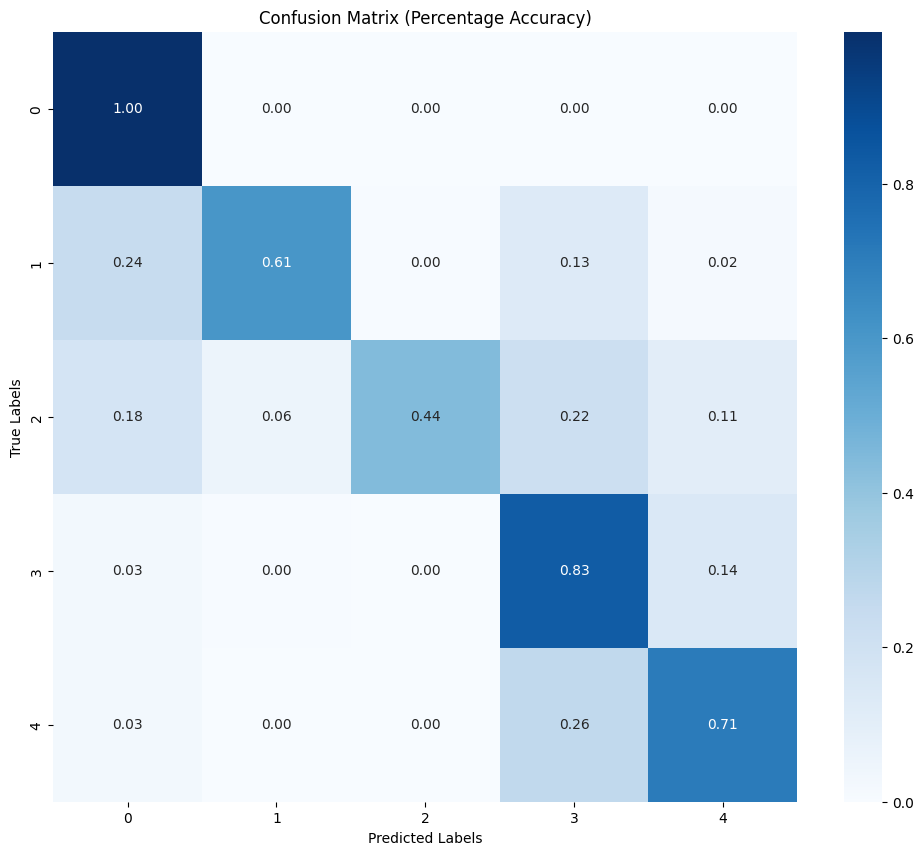

In [9]:
# Predict the labels for the entire dataset
y_pred = finalModel.predict(X_all_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_all, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix by row (true classes) to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# tmp = cm_normalized[3,3]
# cm_normalized[3,3] = cm_normalized[3,0]
# cm_normalized[3,0] = tmp

# tmp = cm_normalized[4,4]
# cm_normalized[4,4] = cm_normalized[4,0]
# cm_normalized[4,0] = tmp

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(classes), yticklabels=range(classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentage Accuracy)')
plt.show()

### Convert to TensorFlow Lite

In [8]:
# Save the standard model if we want to do further training later
finalModel.save(modelDir, modelName)

# Convert this model to TensorFlow Lite version
finalModel.load_data(X_all_pca)
finalModel.tfline_convert(modelDir, modelName)